# Obtencao da imagem virtual

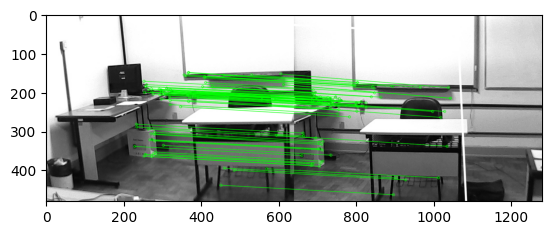

In [35]:
matching_points('2')

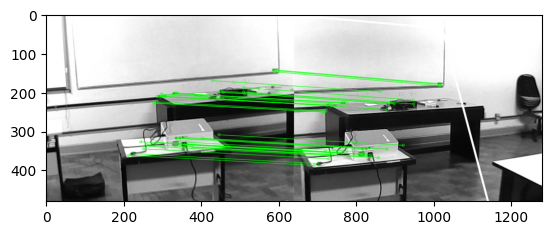

In [28]:
matching_points('3')

# Obtenção da Imagem virtual por relação com o algoritmo do SIFT

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def stitch_rect_image(camera,mtx_1,dist_1,mtx_2,dist_2):
    # Load the images
    img1 = cv2.imread(f'./images_to_virtual/image{camera}/image_1_{camera}.jpg', 1)  # color
    img2 = cv2.imread(f'./images_to_virtual/image{camera}/image_2_{camera}.jpg', 1)  # color

    h_1,  w_1 = img1.shape[:2]
    newcameramtx_1, roi_1 = cv2.getOptimalNewCameraMatrix(mtx_1, dist_1, (w_1,h_1), 1, (w_1,h_1))

    # undistort
    dst_1 = cv2.undistort(img1, mtx_1, dist_1, None, newcameramtx_1)
    # crop the image
    x, y, w, h = roi_1
    dst_1 = dst_1[y:y+h, x:x+w]
    #cv2.imwrite('calibresult.png', dst)

    h_2,  w_2 = img2.shape[:2]
    newcameramtx_2, roi_2 = cv2.getOptimalNewCameraMatrix(mtx_2, dist_2, (w_2,h_2), 1, (w_2,h_2))

    # undistort
    dst_2 = cv2.undistort(img2, mtx_2, dist_2, None, newcameramtx_2)
    # crop the image
    x, y, w, h = roi_2
    dst_2 = dst_2[y:y+h, x:x+w]
    #cv2.imwrite('calibresult.png', dst)
    
    # Initialize SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # Find keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(dst_1, None)
    kp2, des2 = sift.detectAndCompute(dst_2, None)

    # Match features using FLANN (Fast Library for Approximate Nearest Neighbors)
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Store all the good matches as per Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    src,dst = [],[]
    # Homography
    if len(good) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        src.append(src_pts)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        dst.append(dst_pts)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        # Get the size of the resulting stitched image
        h1, w1 = dst_1.shape[:2]
        h2, w2 = dst_2.shape[:2]
        corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
        corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        corners2_transformed = cv2.perspectiveTransform(corners2, M)
        corners = np.concatenate((corners1, corners2_transformed), axis=0)

        [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)
        translation = -np.float32([xmin, ymin])
        H_translation = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

        # Stitch the images together
        result = cv2.warpPerspective(dst_1, H_translation @ M, (xmax - xmin, ymax - ymin))
        result[int(translation[1]):h2 + int(translation[1]), int(translation[0]):w2 + int(translation[0])] = dst_2

    else:
        print("Not enough matches are found - %d/%d" % (len(good), 10))
        matchesMask = None

    # Show the result
    cv2.imshow('Result', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return result,src,dst

In [27]:
def get_matched_points(img1, img2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    # Get the matching points
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    return src_pts, dst_pts

img1 = cv2.imread('./images_virtual/virtual_1.jpg', 0) # queryImage
img2 = cv2.imread('./images_virtual/virtual_2.jpg', 0) # trainImage

src_pts, dst_pts = get_matched_points(img1, img2)

Definindo mtx_1 ... etc do código anterior para teste

In [33]:
mtx_1 = np.array([[999.61846853,   0.,         217.2324828 ],
 [  0.,         997.58793234, 223.2101505 ],
 [  0.,           0.,           1.        ]])

dist_1 = np.array([[-0.14508958, -0.09740103,  0.00095321, -0.00344546,  0.12604606]])

mtx_2 = np.array([[1.00783570e+03, 0.00000000e+00, 2.72030623e+02],
 [0.00000000e+00, 1.00546347e+03, 2.54104646e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

dist_2 = np.array([[-2.11834165e-01,  3.03342912e-01,  3.78222480e-04, -1.85460909e-03,
  -1.82561076e+00]])

In [17]:
stitched_image_1 = stitch_rect_image('1',mtx_1,dist_1,mtx_2,dist_2)
cv2.imwrite('./images_virtual/virtual_1.jpg',stitched_image_1)
stitched_image_2 = stitch_rect_image('2',mtx_1,dist_1,mtx_2,dist_2)
cv2.imwrite('./images_virtual/virtual_2.jpg',stitched_image_2)
stitched_image_3 = stitch_rect_image('3',mtx_1,dist_1,mtx_2,dist_2)
cv2.imwrite('./images_virtual/virtual_3.jpg',stitched_image_3)

True

In [38]:
with open('./coleta_pontos_homologos/pontos_homologos.txt', 'w') as f:
    f.write('src_1 1:\n')
    f.write(str(src_1))
    f.write('\n')

    f.write('dst_1 2:\n')
    f.write(str(dst_1))
    f.write('\n')

    f.write('src_2 1:\n')
    f.write(str(src_2))
    f.write('\n')

    f.write('dst_2 2:\n')
    f.write(str(dst_2))
    f.write('\n')

    f.write('src_3 1:\n')
    f.write(str(src_3))
    f.write('\n')

    f.write('dst_3 2:\n')
    f.write(str(dst_3))
    f.write('\n')